In [43]:
from google.colab import drive
path=drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
import zipfile as zf
files = zf.ZipFile("/content/drive/MyDrive/dataset.zip", 'r')
files.extractall('')
files.close()

In [45]:
# importing important libraries

import torch
from torch import nn

import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor, v2

from torch.utils.data import DataLoader, random_split, Dataset

from imblearn.over_sampling import SMOTE




import matplotlib.pyplot  as plt

from tqdm.auto import tqdm

import os

from pathlib import Path

In [46]:
# checking if gpu is available

if torch.cuda.is_available():
    device = "cuda" # NVIDIA GPU
# elif torch.backends.mps.is_available():
#     device = "mps" # Apple GPU
else:
    device = "cpu" # Defaults to CPU if NVIDIA GPU/Apple GPU aren't available

print(f"Using device: {device}")

Using device: cuda


In [47]:
# lets prepare our data for training and testing and do some EDA
import numpy as np
from imblearn.over_sampling import SMOTE
from torch.utils.data import TensorDataset, DataLoader
import torch
root_dir= "Alzheimer_s Dataset"
train_dir = os.path.join(root_dir,'train')

simple_transform = v2.Compose([
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor(),
])

transform = transform = v2.Compose([


        v2.ColorJitter(brightness=0.5),  # Brightness adjustment


        v2.RandomAffine(degrees=0, scale=(0.98, 1.2)), # Zooming


        v2.Pad(padding=5, fill=0),  # Filling (padding with zeros)

    v2.RandomHorizontalFlip(p=0.4),  # Flipping
    v2.RandomAdjustSharpness(sharpness_factor=2,p=0.5),
    v2.Resize((160, 160)),  # Rescaling
    v2.CenterCrop(size=(150,150)),
    v2.Grayscale(num_output_channels=1),
    v2.ToTensor(),



])
simple_train_data =  datasets.ImageFolder(train_dir,transform=simple_transform)
# now that we have sat the train and test directories we will prepare it to make it as a dataset using datasets.ImageFolder
train_data = datasets.ImageFolder(train_dir,transform=transform)

train_size = int(0.7 * len(train_data))
val_size = int(0.15 * len(train_data))
test_size = len(train_data) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(train_data, [train_size, val_size, test_size])





# let check the data now
print(len(train_data.samples)) #

class_names = train_data.classes
class_idx = train_data.class_to_idx


batch_size = 50

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)





6400


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [48]:

 root_dir= "Alzheimer_s Dataset"
 for dirpath, dirnames, filenames in os.walk(root_dir):
  print(f" directory name:{dirnames} files lens:{len(filenames)}")



 directory name:['train'] files lens:1
 directory name:['NonDemented', 'VeryMildDemented', 'ModerateDemented', 'MildDemented'] files lens:1
 directory name:[] files lens:3200
 directory name:[] files lens:2240
 directory name:[] files lens:64
 directory name:[] files lens:896


{'MildD': 896, 'ModerateD': 64, 'VeryMildD': 2240, 'NonD': 3200}


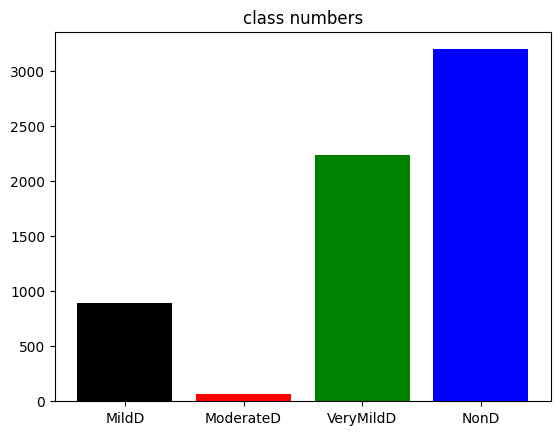

In [49]:
# befor applying SMOTE imbalance classes
MildDemented = os.path.join(train_dir,'MildDemented')
ModerateDemented= os.path.join(train_dir,'ModerateDemented')
VeryMildDemented=os.path.join(train_dir,'VeryMildDemented')
NonDemented=os.path.join(train_dir,'NonDemented')


num_of_classes_in_training =  {
    'MildD':len(os.listdir(MildDemented)),
    'ModerateD':len(os.listdir(ModerateDemented)),
    'VeryMildD':len(os.listdir(VeryMildDemented)),
    'NonD':len(os.listdir(NonDemented))
}
print(num_of_classes_in_training)
plt.bar(num_of_classes_in_training.keys(),num_of_classes_in_training.values(),color=['black','red','green','blue']);
plt.title('class numbers');

In [50]:
print(len(train_loader.dataset))

4480


In [51]:
# applying SMOTE to balance classes and see whether it improves the performance

X = []
y = []
for img, label in train_data:
    X.append(img.numpy().flatten())  # Flatten the image
    y.append(label)

X = np.array(X)
y = np.array(y)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Convert back to PyTorch tensors
X_resampled = torch.from_numpy(X_resampled).float().view(-1, 1, 150, 150)  # Reshape back to image format
y_resampled = torch.from_numpy(y_resampled).long()

# Create a new TensorDataset
balanced_dataset = TensorDataset(X_resampled, y_resampled)




class TransformedTensorDataset(Dataset):
    def __init__(self, tensor_dataset, transform=None):
        self.tensor_dataset = tensor_dataset
        self.transform = transform

    def __getitem__(self, index):
        img, label = self.tensor_dataset[index]

        # Convert tensor to PIL Image for transforms
        img = transforms.ToPILImage()(img)

        if self.transform:
            img = self.transform(img)

        return img, label

    def __len__(self):
        return len(self.tensor_dataset)

# # Create the transformed dataset
transformed_balanced_dataset = TransformedTensorDataset(balanced_dataset, transform=transform)

# print(len(transformed_balanced_dataset))


In [52]:
print(len(transformed_balanced_dataset))

# splitting the new data between train,validation and test


train_size = int(0.7 * len(transformed_balanced_dataset))
val_size = int(0.15 * len(transformed_balanced_dataset))
test_size = len(transformed_balanced_dataset) - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(transformed_balanced_dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)





# let check the data now
print(len(transformed_balanced_dataset.tensor_dataset))

class_names = train_data.classes
class_idx = train_data.class_to_idx


12800
12800


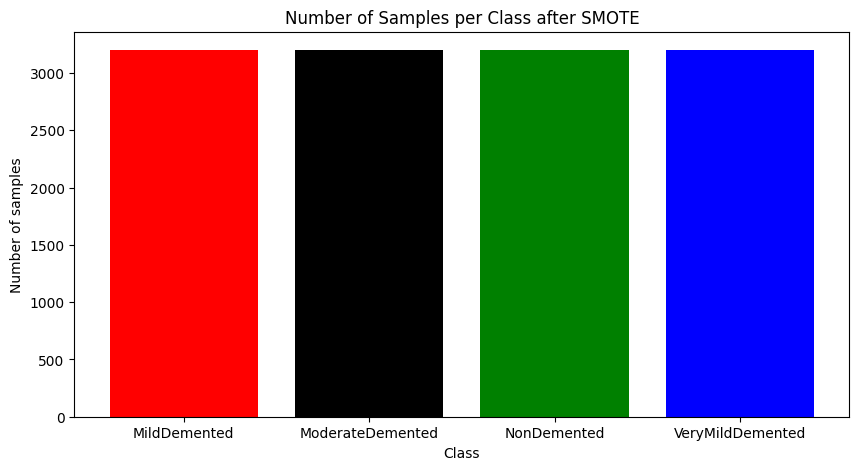

In [53]:
# after applying smote


unique, counts = np.unique(y_resampled, return_counts=True)

unique,counts
# new number of sample per class object
new_number_of_classes={}


for i in range(len(unique)):
  new_number_of_classes[class_names[i]] = counts[i]


new_number_of_classes

# Plot the bar graph
plt.figure(figsize=(10, 5))
plt.bar(new_number_of_classes.keys(), new_number_of_classes.values(), color=['red','black','green','blue'])
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Number of Samples per Class after SMOTE')
plt.show()


torch.Size([1, 208, 176])


(-0.5, 149.5, 149.5, -0.5)

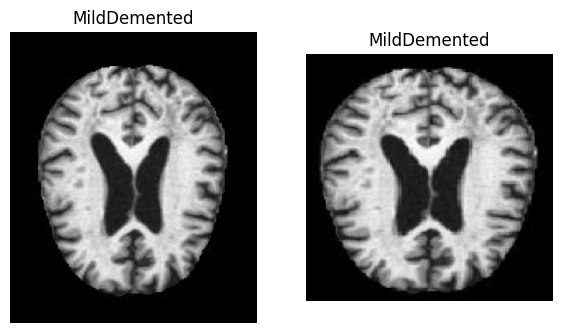

In [83]:
# let visualize images after and before data augmentation

plt.figure(figsize=(7,6))

image,label  = simple_train_data[6]

# augmented data
image1,label1 = train_data[6]

print(image.shape)

plt.subplot(1,2,1)
plt.imshow(image.permute(1, 2, 0),cmap='gray');
plt.title(f"{class_names[label]}")
plt.axis(False)
plt.subplot(1,2,2)
plt.imshow(image1.permute(1, 2, 0),cmap='gray');
plt.title(f"{class_names[label1]}")
plt.axis(False)

In [84]:
# let visualize some random images from the dataset
def displayRandomImage(data,nrows:int=4,ncols:int=4):
  """
  data will be from train1 and train2 to see the difference
  nrows are number of rows and by default it will be 4 unless specified
  ncols are number of cols and by default it will be 4 unless specified
  """
  plt.figure(figsize=(9,9))
  torch.manual_seed(42)

  for i in range(1,nrows*ncols+1):

    random_idx = torch.randint(0,len(data),size=[1]).item()
    image,label = data[random_idx]
    plt.subplot(nrows,ncols,i)
    plt.imshow(image.permute(1, 2, 0),cmap='gray');
    plt.title(class_names[label]);
    plt.axis(False);





images before preprocessing.....



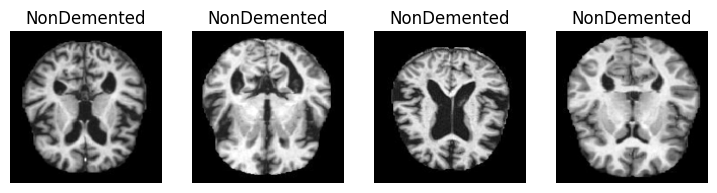

In [85]:
print("images before preprocessing.....\n")

displayRandomImage(train_data,nrows=1,ncols=4)

images after preprocessing.....



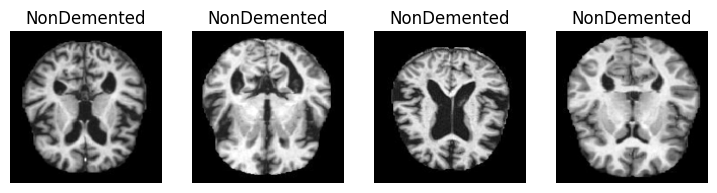

In [86]:
print("images after preprocessing.....\n")

displayRandomImage(train_data,nrows=1,ncols=4)

In [58]:
# pip install torchsampler


In [59]:
# # there is a clear class imbalance we will train our model with class imbalance if it performs bad we will perform class balancing techniques
# # lets define our custom cnn
import torch.nn.functional as F

# class customCNN(nn.Module):
#   def __init__(self, input_shape:int,filters:int,output_shape:int):
#     super().__init__()

#     self.conv1 = nn.Sequential(
#         nn.Conv2d(in_channels=input_shape,
#                   out_channels=filters,
#                   kernel_size=2,stride=1),
#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2)
#     )
#     self.conv2 = nn.Sequential(
#         nn.Conv2d(in_channels=filters,
#                   out_channels=filters,
#                   kernel_size=2,stride=1),

#         nn.ReLU(),
#         nn.MaxPool2d(kernel_size=2)

#     )
#     # self.conv3 = nn.Sequential(
#     #     nn.Conv2d(in_channels=filters,
#     #               out_channels=filters,
#     #               kernel_size=2,stride=1),

#     #     nn.ReLU(),
#     #     nn.MaxPool2d(kernel_size=2)

#     # )

#     self.classifer = nn.Sequential(
#         nn.Flatten(),
#         nn.Linear(in_features=filters*36*36 ,  # Calculate this based on input image size
#                       out_features=150),
#         nn.ReLU(),
#         nn.Linear(in_features=150,out_features=4)



#     )


#   def forward(self,x):

#     x = self.conv1(x)
#     # print(f"Output shape of conv_block_2: {x.shape}")
#     x = self.conv2(x)
#     # x = self.conv3(x)


#     # print(f"Output shape of conv_block_2: {x.shape}")

#     x= self.classifer(x)

#     return x


class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32 * 37 * 37, 160)
        self.relu2 = nn.ReLU()
        self.fc2 = nn.Linear(160, 4)

    def forward(self, x):
        x = self.pool(self.relu1(self.conv1(x)))
        x = self.pool(self.conv2(x))
        # print(f"x shape:{x.shape}")
        x = self.flatten(x)
        x = self.relu2(self.fc1(x))
        x = self.fc2(x)
        return x

model1 = SimpleCNN().to(device)



In [60]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo



In [61]:
# model1 = customCNN(input_shape=1,filters=32,output_shape=4).to(device)
from torchinfo import summary
summary(model1, input_size=[1, 1, 150, 150])

Layer (type:depth-idx)                   Output Shape              Param #
SimpleCNN                                [1, 4]                    --
├─Conv2d: 1-1                            [1, 32, 150, 150]         320
├─ReLU: 1-2                              [1, 32, 150, 150]         --
├─MaxPool2d: 1-3                         [1, 32, 75, 75]           --
├─Conv2d: 1-4                            [1, 32, 75, 75]           9,248
├─MaxPool2d: 1-5                         [1, 32, 37, 37]           --
├─Flatten: 1-6                           [1, 43808]                --
├─Linear: 1-7                            [1, 160]                  7,009,440
├─ReLU: 1-8                              [1, 160]                  --
├─Linear: 1-9                            [1, 4]                    644
Total params: 7,019,652
Trainable params: 7,019,652
Non-trainable params: 0
Total mult-adds (M): 66.23
Input size (MB): 0.09
Forward/backward pass size (MB): 7.20
Params size (MB): 28.08
Estimated Total Size (MB):

In [62]:
rand_image_tensor = torch.randn(size=(1, 150, 150))
rand_image_tensor=rand_image_tensor.to(device)

In [63]:
# now trying to see the flatten shape
model1(rand_image_tensor.unsqueeze(0))

tensor([[ 0.0457,  0.0308, -0.0331,  0.1641]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [64]:
# from torch.optim.lr_scheduler import ReduceLROnPlateau
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model1.parameters(),lr=0.001)


# scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[6,10,15], gamma=0.001)

In [65]:
def train_benchmark(start:float, end:float, device:torch.device = None):
    """
    start: is the start time of the training benchmark

    end: is the end time of the training benchmark

    device: is the device which is going to run the training benchmark either 'cpu' or 'gpu' in case of mac m1 'mps'
    """
    print(f" training benchmark on {device} took {(end-start):.3f} seconds")


In [66]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [67]:
train_loss_values=[]
train_acc_values= []

def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):



    # """Performs a training step with the model trying to learn on data_loader."""
  global train_loss_values
  global train_acc_values
  train_loss, train_acc = 0, 0

  # Put model into training mode
  model.train()

    # Add a loop to loop through the training batches
  for batch, (X, y) in enumerate(data_loader):
        # Put data on target device
      X, y = X.to(device), y.to(device)

        # 1. Forward pass (outputs the raw logits from the model)
      y_pred = model(X)

        # 2. Calculate loss and accuracy (per batch)
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() # accumulate train loss
      train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1)) # go from logits -> prediction labels

        # 3. Optimizer zero grad
      optimizer.zero_grad()

        # 4. Loss backward
      loss.backward()

        # 5. Optimizer step (update the model's parameters once *per batch*)
      optimizer.step()
      # scheduler.step(train_loss)

    # Divide total train loss and acc by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  train_loss_values.append(train_loss)
  train_acc_values.append(train_acc)
  print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f}%")



In [68]:
validation_loss_values=[]
validation_acc_values=[]
def valid_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

    # """Performs a validation loop step on model going over data_loader."""

  global validation_loss_values
  global validation_acc_values
  valid_loss, valid_acc = 0, 0

    # Put the model in eval mode
  model.eval()

    # Turn on inference mode context manager
  with torch.inference_mode():

    for X, y in data_loader:

            # Send the data to the target device
      X, y = X.to(device), y.to(device)

            # 1. Forward pass (outputs raw logits)
      valid_pred = model(X)

            # 2. Calculate the loss and accuracy
      valid_loss += loss_fn(valid_pred, y)
      valid_acc += accuracy_fn(y_true=y, y_pred=valid_pred.argmax(dim=1))  # go from logits -> prediction labels

        # Adjust metrics and print out
    valid_loss /= len(data_loader)
    valid_acc /= len(data_loader)
    validation_loss_values.append(valid_loss)
    validation_acc_values.append(valid_acc)
    print(f"valid loss: {valid_loss:.5f} | valid acc: {valid_acc:.2f}%\n")


In [69]:
from timeit import default_timer as timer

start = timer()
EPOCHS= 60

for epoch in tqdm(range(EPOCHS)):

  train_step(model1,train_loader,loss_fn,optimizer,accuracy_fn,device)
  valid_step(model1,val_loader,loss_fn,accuracy_fn,device)



end =timer()
train_benchmark(start=start,end=end,device=str(next(model1.parameters()).device))

  0%|          | 0/60 [00:00<?, ?it/s]

Train loss: 1.10730 | Train acc: 49.48%
valid loss: 0.80254 | valid acc: 63.03%

Train loss: 0.70602 | Train acc: 67.28%
valid loss: 0.64731 | valid acc: 68.28%

Train loss: 0.62092 | Train acc: 71.69%
valid loss: 0.60050 | valid acc: 73.23%

Train loss: 0.55431 | Train acc: 74.56%
valid loss: 0.52301 | valid acc: 76.56%

Train loss: 0.50084 | Train acc: 78.16%
valid loss: 0.50619 | valid acc: 78.74%

Train loss: 0.45472 | Train acc: 80.24%
valid loss: 0.42323 | valid acc: 82.10%

Train loss: 0.39908 | Train acc: 82.90%
valid loss: 0.40111 | valid acc: 82.31%

Train loss: 0.35593 | Train acc: 85.28%
valid loss: 0.37120 | valid acc: 85.59%

Train loss: 0.30388 | Train acc: 87.52%
valid loss: 0.33440 | valid acc: 86.31%

Train loss: 0.27589 | Train acc: 89.22%
valid loss: 0.30244 | valid acc: 87.28%

Train loss: 0.24397 | Train acc: 90.66%
valid loss: 0.31060 | valid acc: 87.79%

Train loss: 0.21275 | Train acc: 92.17%
valid loss: 0.37928 | valid acc: 86.51%

Train loss: 0.18977 | Train 

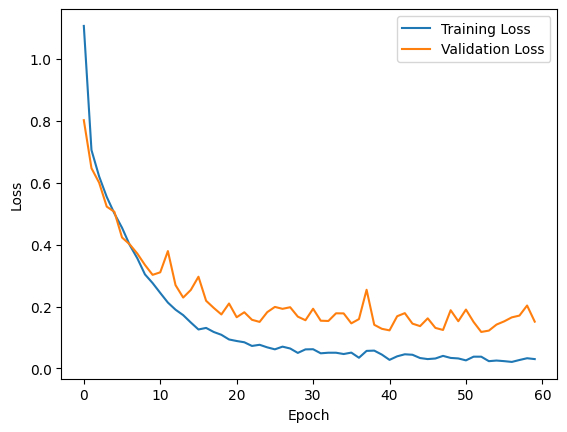

In [70]:
# let's plot the train and test loss functions
len(train_acc_values)
epochs = list(range(len(train_loss_values)))

# Plot the losses
plt.plot(epochs, torch.tensor(train_loss_values).cpu(), label='Training Loss')
plt.plot(epochs, torch.tensor(validation_loss_values).cpu(), label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

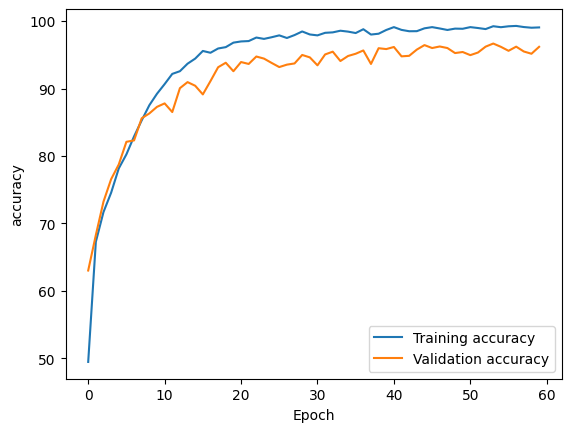

In [71]:
# accuracylen(train_acc_values)
epochs = list(range(len(train_acc_values)))

# Plot the losses
plt.plot(epochs, torch.tensor(train_acc_values).cpu(), label='Training accuracy')
plt.plot(epochs, torch.tensor(validation_acc_values).cpu(), label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [72]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # Prepare the sample (add a batch dimension and pass to target device)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # Forward pass (model outputs raw logits)
      pred_logit = model(sample)

      # Get prediction probability (logit -> prediction probability)
      pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

      # Get pred_prob off the GPU for further calculations
      pred_probs.append(pred_prob.cpu())

  # Stack the pred_probs to turn list into a tensor
  return torch.stack(pred_probs)

In [73]:
import random
# random.seed(42)
print(len(test_dataset))
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=1920):
  test_samples.append(sample)
  test_labels.append(label)

# View the first sample shape
test_samples[0].shape

1920


torch.Size([1, 150, 150])

In [74]:
pred_probs = make_predictions(model=model1,
                              data=test_samples)

# View first two prediction probabilities
pred_probs[:2]

tensor([[1.9327e-18, 1.0000e+00, 1.1852e-11, 9.2175e-13],
        [7.3351e-11, 1.0000e+00, 1.0396e-12, 7.0572e-07]])

In [75]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([1, 1, 3,  ..., 2, 0, 1])

In [76]:
array_test_labels =[]

for item in test_labels:

  array_test_labels.append(item.item())

# array_test_labels


In [77]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
comparison= {
    'predicted_labels':pred_classes,
    'true labels':array_test_labels
}

import pandas as pd

df= pd.DataFrame(data=comparison)

df.head(50)

accuracy_score(test_labels,pred_classes)*100

96.51041666666667

In [78]:
df.head(20)

,predicted_labels,true labels
0,1,1
1,1,1
2,3,3
3,2,2
4,3,3
5,2,3
6,1,1
7,0,0
8,1,1
9,1,1


              precision    recall  f1-score   support

           0       0.98      0.98      0.98       471
           1       1.00      1.00      1.00       487
           2       0.93      0.96      0.94       453
           3       0.95      0.92      0.94       509

    accuracy                           0.97      1920
   macro avg       0.96      0.97      0.97      1920
weighted avg       0.97      0.97      0.97      1920

{'MildDemented': 0, 'ModerateDemented': 1, 'NonDemented': 2, 'VeryMildDemented': 3}


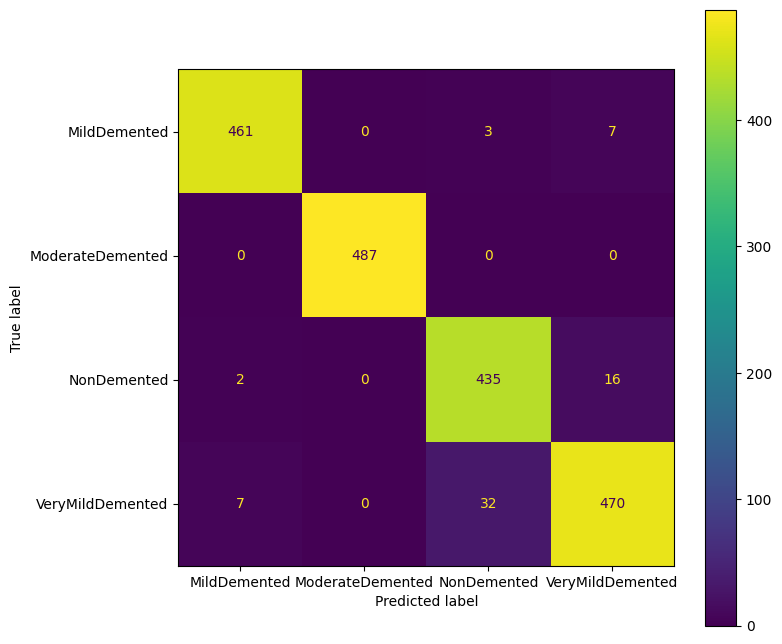

In [79]:
cm = confusion_matrix(pred_classes,array_test_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=class_names)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax)
print(classification_report(pred_classes,array_test_labels))
print(class_idx)

In [80]:

# Create model dictory path
MODEL_PATH = Path(f"{path}/models")
MODEL_PATH.mkdir(parents=True,
                 exist_ok=True)

# Create model save
MODEL_NAME = "My Custom CNN final with SMOTE.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(),
           f=MODEL_SAVE_PATH)

Saving model to: None/models/My Custom CNN final with SMOTE.pth
